Data Preprocessing

In [2]:
import os
from google.colab import drive

drive.mount("/content/drive")
path = "/content/drive/MyDrive/Colab Notebooks//"
os.chdir(path)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

warnings.filterwarnings('ignore')

In [4]:
# Download necessary NLTK resources

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text) or text == '':
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^\w\s]', ' ', text)  # Replace special chars with space
    text = re.sub(r'\d+', ' ', text)  # Replace numbers with space

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text



In [6]:
# Function to get n-grams (either bigrams or trigrams)
def get_ngrams(text, n=2):
    tokens = word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return [' '.join(g) for g in n_grams]


In [7]:
# Simple sentiment function (can be expanded with more sophisticated models)
def get_sentiment_score(text, pos_words, neg_words):
    if not text:
        return 0

    tokens = text.split()
    pos_count = sum(1 for word in tokens if word in pos_words)
    neg_count = sum(1 for word in tokens if word in neg_words)

    if pos_count + neg_count == 0:
        return 0
    return (pos_count - neg_count) / (pos_count + neg_count)


In [8]:
print("Reading data...")
try:
    df = pd.read_csv('imdb-data.csv')
    print(f"Dataset shape: {df.shape}")
    print(df.head())
except Exception as e:
    print(f"Error reading data: {e}")
    exit(1)


Reading data...
Dataset shape: (10009, 4)
   Ratings                                            Reviews          Movies  \
0        1  *Disclaimer: I only watched this movie as a co...  Disaster Movie   
1        1  I am writing this in hopes that this gets put ...  Disaster Movie   
2        1  Really, I could write a scathing review of thi...  Disaster Movie   
3        1  If you saw the other previous spoof movies by ...  Disaster Movie   
4        1  This movie I saw a day early for free and I st...  Disaster Movie   

                                            Resenhas  
0  * Isenção de responsabilidade: eu só assisti e...  
1  Estou escrevendo isso na esperança de que isso...  
2  Realmente, eu poderia escrever uma crítica con...  
3  Se você viu os outros filmes falsificados ante...  
4  Este filme eu vi um dia cedo de graça e ainda ...  


In [9]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Preprocess Reviews column
print("\nPreprocessing Reviews column...")
df['Reviews_clean'] = df['Reviews'].apply(preprocess_text)
print("\nPreprocessing complete.")


Missing values in each column:
Ratings     0
Reviews     0
Movies      0
Resenhas    0
dtype: int64

Preprocessing Reviews column...

Preprocessing complete.


In [10]:
# Handle missing values
df['Reviews_clean'] = df['Reviews_clean'].fillna('')

# Remove empty reviews
empty_reviews = df[df['Reviews_clean'] == '']
print(f"\nNumber of empty reviews after preprocessing: {len(empty_reviews)}")
if len(empty_reviews) > 0:
    print("Removing empty reviews...")
    df = df[df['Reviews_clean'] != '']

# Filter out rating 6 (neutral) as per requirement
print("\nRatings distribution before filtering:")
print(df['Ratings'].value_counts().sort_index())


Number of empty reviews after preprocessing: 0

Ratings distribution before filtering:
Ratings
1      999
2     1002
3     1001
4     1001
5     1000
6     1002
7     1001
8     1001
9     1001
10    1001
Name: count, dtype: int64


In [11]:
df_filtered = df[df['Ratings'] != 6]
print("\nRatings distribution after removing neutral (rating 6):")
print(df_filtered['Ratings'].value_counts().sort_index())

print(f"Original dataset: {len(df)} reviews")
print(f"Filtered dataset (without rating 6): {len(df_filtered)} reviews")
print(f"Removed {len(df) - len(df_filtered)} reviews with rating 6")



Ratings distribution after removing neutral (rating 6):
Ratings
1      999
2     1002
3     1001
4     1001
5     1000
7     1001
8     1001
9     1001
10    1001
Name: count, dtype: int64
Original dataset: 10009 reviews
Filtered dataset (without rating 6): 9007 reviews
Removed 1002 reviews with rating 6


In [12]:
# Create binary sentiment categories
df_filtered['sentiment_category'] = df_filtered['Ratings'].apply(
    lambda x: 'Negative' if x <= 5 else 'Positive')

print("\nSentiment categories counts:")
print(df_filtered['sentiment_category'].value_counts())

# Save processed data
print("Saving processed data...")
df_filtered.to_csv('imdb-data-binary-sentiment.csv', index=False)



Sentiment categories counts:
sentiment_category
Negative    5003
Positive    4004
Name: count, dtype: int64
Saving processed data...


Data Exploration


1. Analyze Ratings Distribution
Descriptive Statistics of Ratings:
count    9007.000000
mean        5.445098
std         3.022541
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: Ratings, dtype: float64


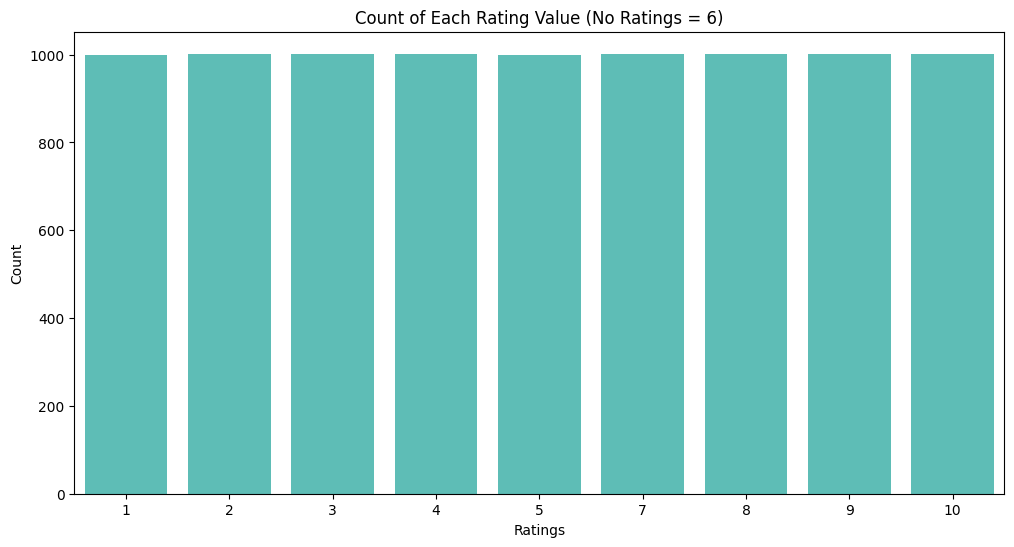

In [13]:
# 1. Analyze Ratings Distribution
print("\n1. Analyze Ratings Distribution")
print("Descriptive Statistics of Ratings:")
print(df_filtered['Ratings'].describe())

# Plot count plot for Ratings
plt.figure(figsize=(12, 6))
sns.countplot(x='Ratings', data=df_filtered, color='#4ecdc4')
plt.title('Count of Each Rating Value (No Ratings = 6)')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()


2. Analyze Length of Reviews_clean

Statistics of Review Length (Characters):
count    9007.000000
mean      673.868880
std       544.436342
min        14.000000
25%       372.000000
50%       505.000000
75%       819.500000
max      6819.000000
Name: review_length, dtype: float64

Statistics of Word Count:
count    9007.000000
mean      101.002887
std        79.680739
min         1.000000
25%        57.000000
50%        76.000000
75%       122.000000
max       954.000000
Name: word_count, dtype: float64


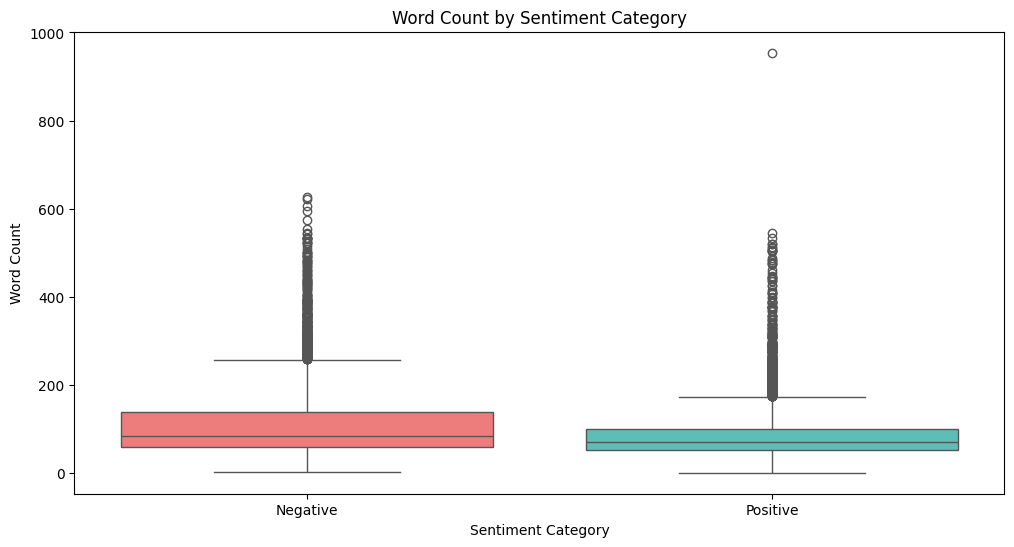

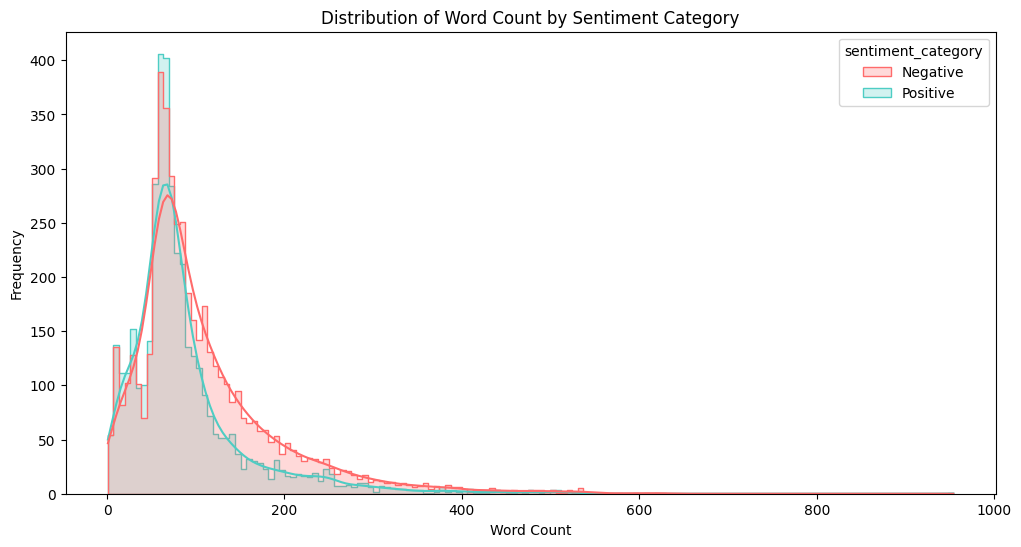

In [14]:
# 2. Analyze Length of Reviews_clean
print("\n2. Analyze Length of Reviews_clean")
df_filtered['review_length'] = df_filtered['Reviews_clean'].apply(len)
df_filtered['word_count'] = df_filtered['Reviews_clean'].apply(lambda x: len(x.split()))

print("\nStatistics of Review Length (Characters):")
print(df_filtered['review_length'].describe())

print("\nStatistics of Word Count:")
print(df_filtered['word_count'].describe())

# Plot boxplot and histogram for review length
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment_category', y='word_count', data=df_filtered,
            palette={'Negative': '#ff6b6b', 'Positive': '#4ecdc4'})
plt.title('Word Count by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Word Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df_filtered, x='word_count', hue='sentiment_category',
             element='step', kde=True, palette={'Negative': '#ff6b6b', 'Positive': '#4ecdc4'})
plt.title('Distribution of Word Count by Sentiment Category')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


3. Correlation between Review Length and Ratings


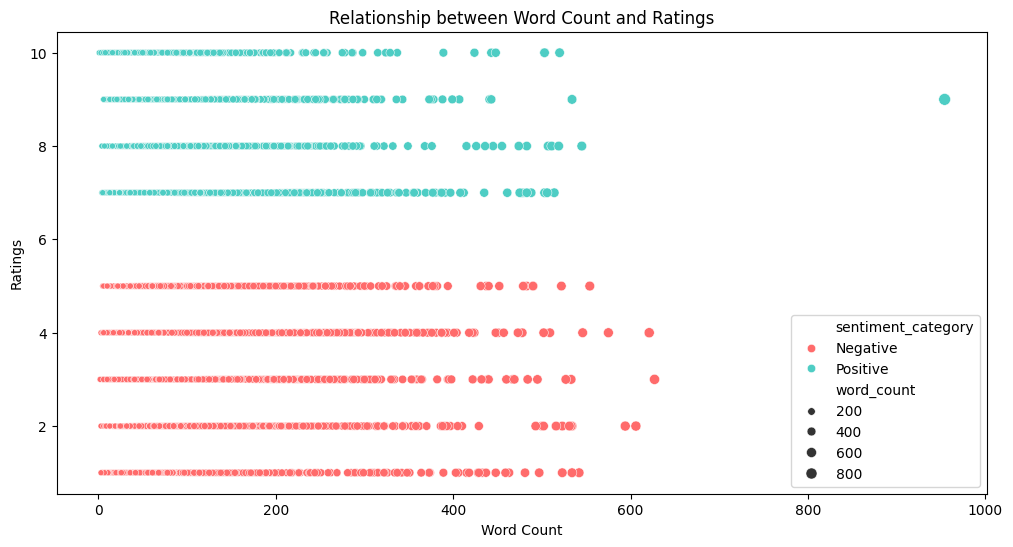

Pearson Correlation between Word Count and Ratings:
-0.12072421007041935


In [15]:
# 3. Correlation between Review Length and Ratings
print("\n3. Correlation between Review Length and Ratings")
plt.figure(figsize=(12, 6))
sns.scatterplot(x='word_count', y='Ratings', hue='sentiment_category',
                size='word_count', data=df_filtered,
                palette={'Negative': '#ff6b6b', 'Positive': '#4ecdc4'})
plt.title('Relationship between Word Count and Ratings')
plt.xlabel('Word Count')
plt.ylabel('Ratings')
plt.show()

print("Pearson Correlation between Word Count and Ratings:")
print(df_filtered['word_count'].corr(df_filtered['Ratings']))



4. Generate Word Clouds for Each Sentiment Category


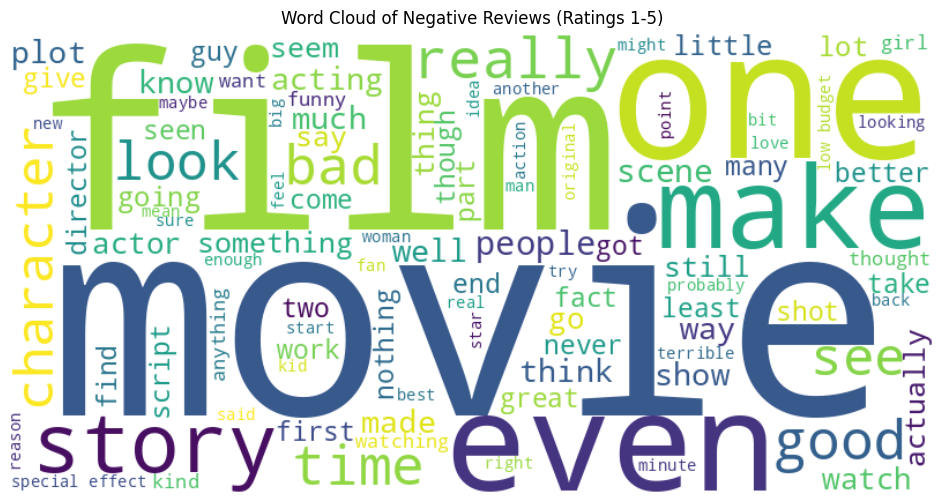

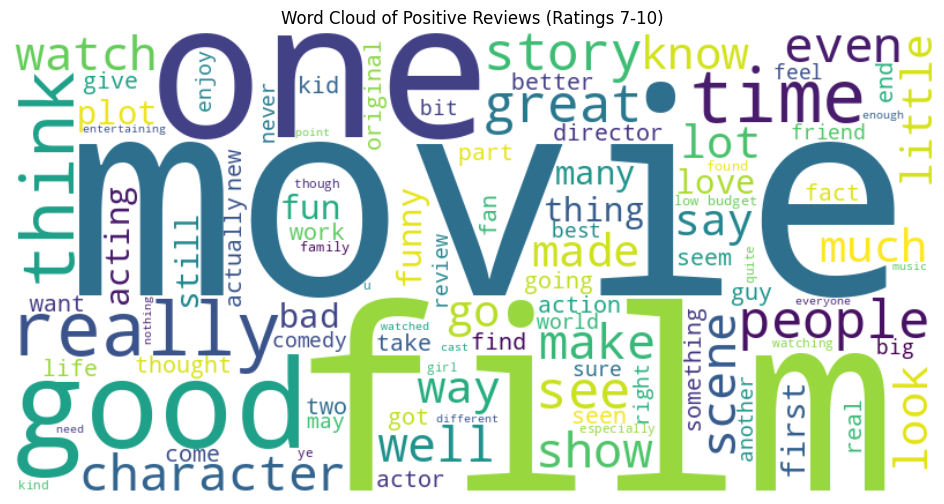

In [16]:
print("\n4. Generate Word Clouds for Each Sentiment Category")

def generate_wordcloud(df, sentiment, title):
    text = ' '.join(df[df['sentiment_category'] == sentiment]['Reviews_clean'])
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=100, colormap='viridis').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(df_filtered, 'Negative',
                   'Word Cloud of Negative Reviews (Ratings 1-5)')
generate_wordcloud(df_filtered, 'Positive',
                   'Word Cloud of Positive Reviews (Ratings 7-10)')



5. Find Common Bigrams and Trigrams

Top 20 2-grams Most Common in Negative Reviews:
special effect: 622
low budget: 583
look like: 529
bad movie: 439
worst movie: 323
movie ever: 308
ever seen: 270
sci fi: 267
horror movie: 258
movie like: 257
movie bad: 247
watch movie: 237
bad acting: 229
good movie: 221
year old: 220
waste time: 218
really bad: 198
one worst: 192
pretty much: 190
make movie: 187


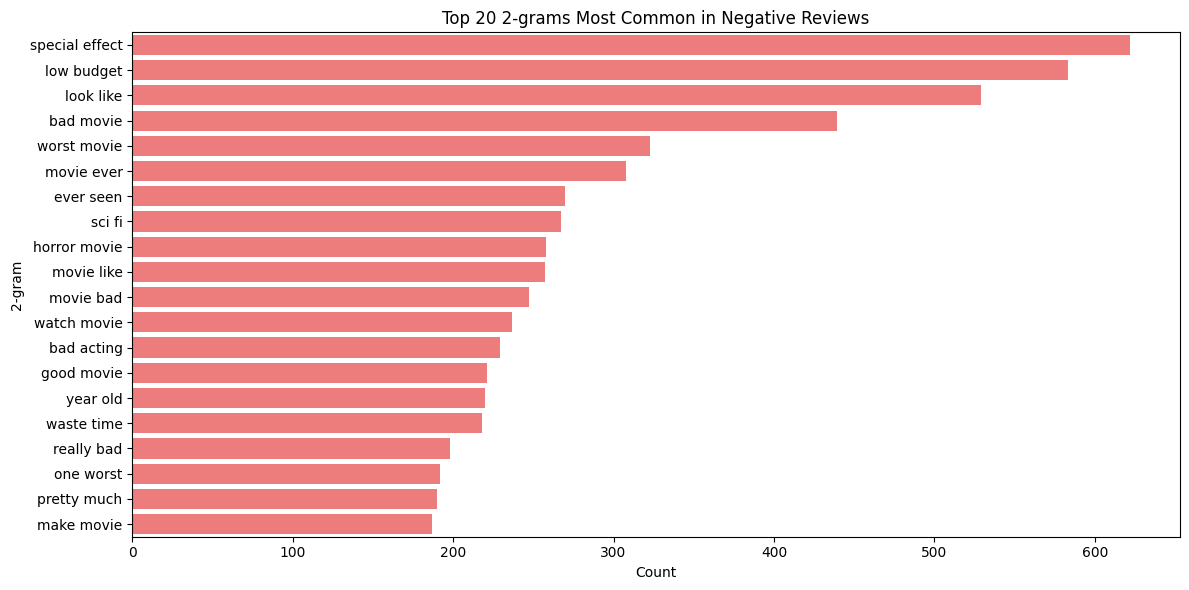


Top 20 2-grams Most Common in Positive Reviews:
low budget: 389
special effect: 335
horror movie: 223
movie like: 222
watch movie: 209
horror film: 209
movie ever: 197
see movie: 194
look like: 191
sci fi: 177
good movie: 172
ever seen: 162
great movie: 162
bad movie: 161
well done: 152
pretty good: 151
story line: 151
like movie: 146
best movie: 142
even though: 136


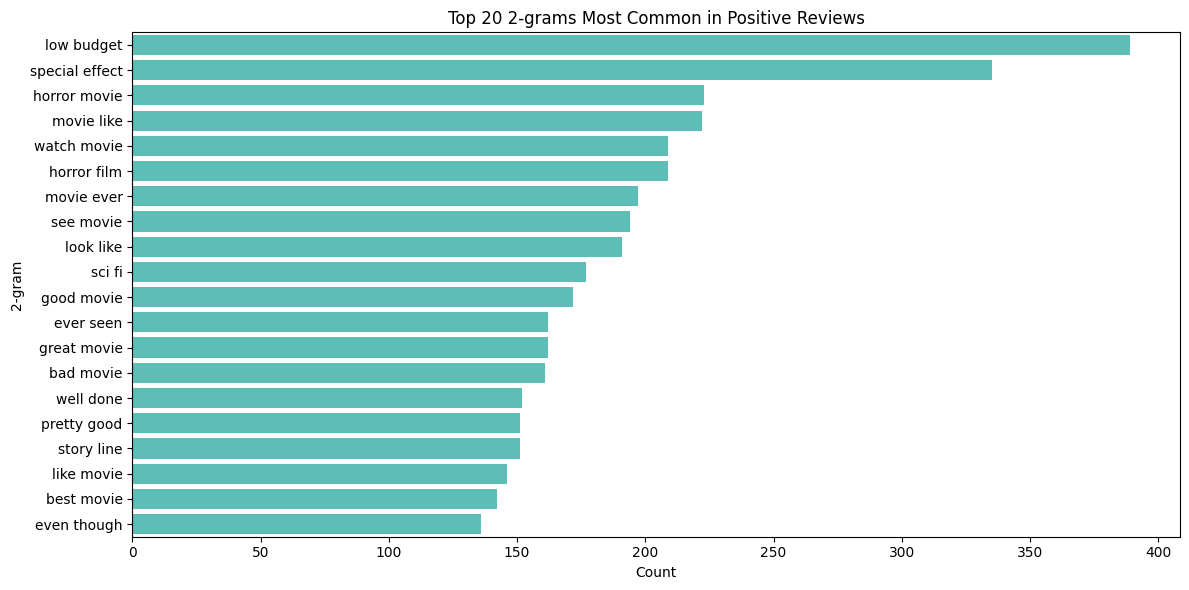


Top 20 3-grams Most Common in Negative Reviews:
worst movie ever: 193
mystery science theater: 112
movie ever seen: 108
low budget movie: 101
worst film ever: 74
movie ever made: 69
one worst movie: 68
low budget film: 63
sci fi movie: 44
film ever seen: 43
sci fi channel: 41
low budget horror: 35
manos hand fate: 34
film ever made: 34
watch watch watch: 34
night living dead: 34
mega shark v: 33
one worst film: 32
bad acting bad: 31
waste time money: 29


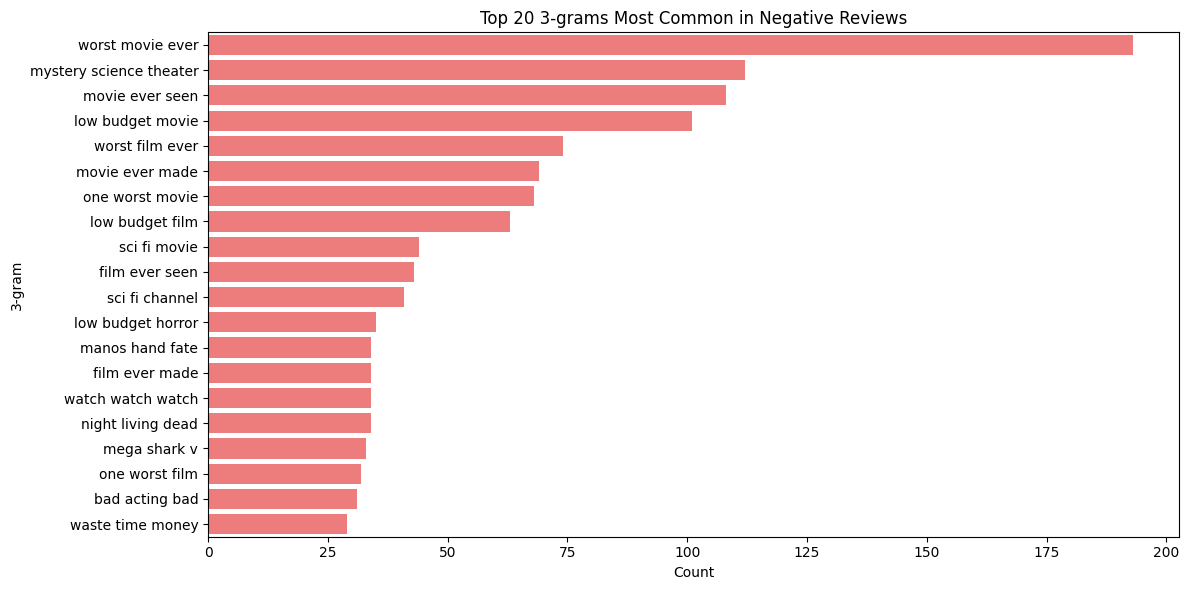


Top 20 3-grams Most Common in Positive Reviews:
movie ever seen: 61
low budget film: 58
best movie ever: 49
low budget movie: 48
movie ever made: 48
worst movie ever: 40
best movie time: 38
rated graphic violence: 37
graphic violence language: 34
time best movie: 34
movie time best: 33
go see movie: 31
low budget horror: 30
sci fi channel: 28
film ever seen: 25
film ever made: 25
really enjoyed movie: 23
sci fi film: 21
night living dead: 21
worst film ever: 20


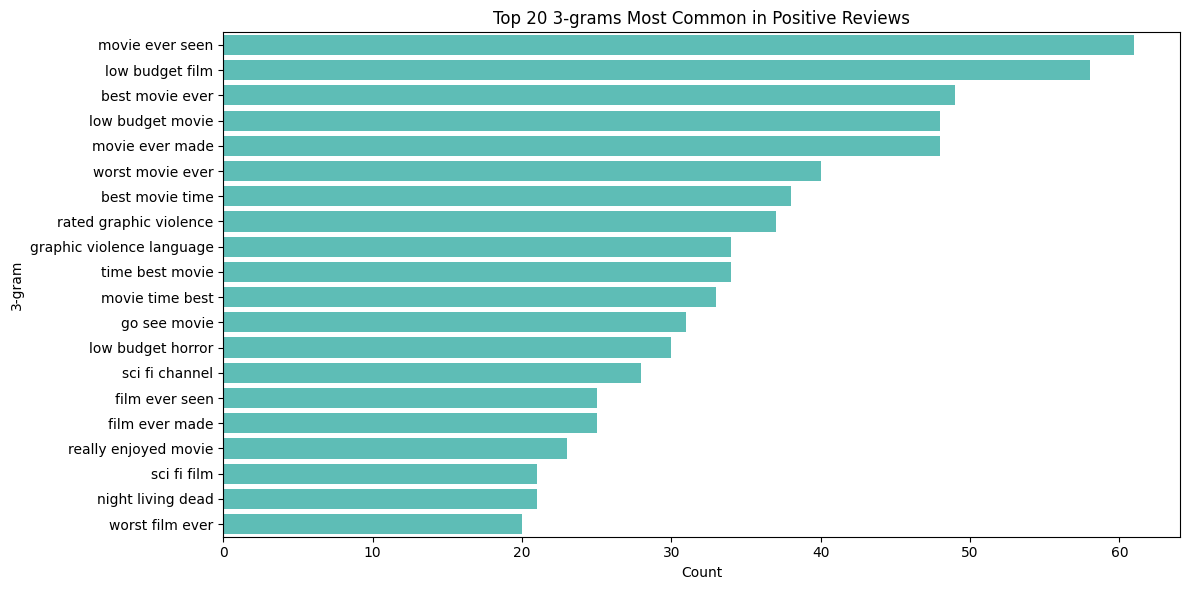

In [17]:
# 5. Find Common N-grams for Each Sentiment Category
print("\n5. Find Common Bigrams and Trigrams")

def analyze_ngrams(df, sentiment, n=2, filename_prefix=''):
    text = ' '.join(df[df['sentiment_category'] == sentiment]['Reviews_clean'])
    n_grams = get_ngrams(text, n=n)
    n_gram_counts = Counter(n_grams)

    print(f"\nTop 20 {n}-grams Most Common in {sentiment} Reviews:")
    for n_gram, count in n_gram_counts.most_common(20):
        print(f"{n_gram}: {count}")

    top_ngrams = pd.DataFrame(n_gram_counts.most_common(20), columns=[f'{n}-gram', 'Count'])
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y=f'{n}-gram', data=top_ngrams,
                palette=['#ff6b6b'] if sentiment == 'Negative' else ['#4ecdc4'])
    plt.title(f'Top 20 {n}-grams Most Common in {sentiment} Reviews')
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_{sentiment.lower()}.png')
    plt.show()

    return n_gram_counts

neg_bigrams = analyze_ngrams(df_filtered, 'Negative', n=2, filename_prefix='bigrams')
pos_bigrams = analyze_ngrams(df_filtered, 'Positive', n=2, filename_prefix='bigrams')
neg_trigrams = analyze_ngrams(df_filtered, 'Negative', n=3, filename_prefix='trigrams')
pos_trigrams = analyze_ngrams(df_filtered, 'Positive', n=3, filename_prefix='trigrams')


In [18]:
# 6. TF-IDF Analysis to Find Distinctive Words and Phrases
print("\n6. TF-IDF Analysis to Find Distinctive Words and Phrases")

def get_top_tfidf_features(texts, vectorizer, top_n=20):
    X = vectorizer.transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    sums = X.sum(axis=0).A1
    top_indices = sums.argsort()[-top_n:][::-1]
    top_features = [(feature_names[i], sums[i]) for i in top_indices]
    return top_features

negative_reviews = df_filtered[df_filtered['sentiment_category'] == 'Negative']['Reviews_clean'].tolist()
positive_reviews = df_filtered[df_filtered['sentiment_category'] == 'Positive']['Reviews_clean'].tolist()

# TF-IDF for Unigrams
word_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7)
word_vectorizer.fit(df_filtered['Reviews_clean'])

negative_words = get_top_tfidf_features(negative_reviews, word_vectorizer)
positive_words = get_top_tfidf_features(positive_reviews, word_vectorizer)

print("\nTop Distinctive Words in Negative Reviews (TF-IDF):")
for word, score in negative_words:
    print(f"{word}: {score:.4f}")

print("\nTop Distinctive Words in Positive Reviews (TF-IDF):")
for word, score in positive_words:
    print(f"{word}: {score:.4f}")



6. TF-IDF Analysis to Find Distinctive Words and Phrases

Top Distinctive Words in Negative Reviews (TF-IDF):
film: 262.4029
bad: 185.1165
one: 169.1490
like: 162.2095
good: 133.2114
even: 124.5922
time: 120.8713
really: 117.3767
make: 117.2060
acting: 116.6295
watch: 108.2631
would: 106.7334
get: 98.9289
story: 97.0210
scene: 95.9589
much: 92.9118
worst: 91.5675
thing: 91.2989
see: 90.7731
could: 89.2546

Top Distinctive Words in Positive Reviews (TF-IDF):
film: 219.8554
good: 130.0686
like: 125.0316
one: 119.2819
great: 115.7343
really: 98.8478
see: 94.6591
watch: 92.8870
people: 88.4038
time: 86.9130
well: 82.9184
story: 82.8627
think: 81.2337
show: 78.6256
would: 78.3886
get: 72.3807
make: 70.5077
fun: 69.9622
horror: 69.9255
bad: 69.6157


In [19]:
!pip install nltk
!pip install scikit-learn

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re, string, unicodedata
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import re
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [21]:
%%time
df = pd.read_csv(r"imdb-data-binary-sentiment.csv", encoding="latin-1")

CPU times: user 375 ms, sys: 38.2 ms, total: 414 ms
Wall time: 530 ms


In [22]:
df.head()

,Ratings,Reviews,Movies,Resenhas,Reviews_clean,sentiment_category
0,1,*Disclaimer: I only watched this movie as a co...,Disaster Movie,* IsenÃ§Ã£o de responsabilidade: eu sÃ³ assist...,disclaimer watched movie conditional agreement...,Negative
1,1,I am writing this in hopes that this gets put ...,Disaster Movie,Estou escrevendo isso na esperanÃ§a de que iss...,writing hope get put previous review film anyo...,Negative
2,1,"Really, I could write a scathing review of thi...",Disaster Movie,"Realmente, eu poderia escrever uma crÃ­tica co...",really could write scathing review turd sandwi...,Negative
3,1,If you saw the other previous spoof movies by ...,Disaster Movie,Se vocÃª viu os outros filmes falsificados ant...,saw previous spoof movie two horrible gentlema...,Negative
4,1,This movie I saw a day early for free and I st...,Disaster Movie,Este filme eu vi um dia cedo de graÃ§a e ainda...,movie saw day early free still feel like got r...,Negative


In [23]:
df["Ratings"].describe()

,Ratings
count,9007.000000
mean,5.445098
std,3.022541
min,1.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,10.000000


In [24]:
df["Reviews_clean"].describe()

,Reviews_clean
count,9007
unique,8990
top,wanted watch movie thought would good intellig...
freq,2


In [25]:
print("Unique reviews:%s" % df.Reviews_clean.nunique())
print("Unique movie names:%s" % df.Movies.nunique())
print("No of ratings:%s" % df.Ratings.count())

Unique reviews:8990
Unique movie names:1756
No of ratings:9007


In [26]:
#Mapping rating data to Binary label 1 (+ve) if rating >=7 and 0 (-ve) if rating <=5 and 2 (neutral) if rating = 6
df['Label'] = df['Ratings'].apply(lambda x: '1' if x >= 7 else ('0' if x<=5 else '2'))
#Removing
df=df[df.Label<'2']
data=df[['Reviews_clean','Reviews','Ratings','Label']]
print(data['Label'].value_counts())

Label
0    5003
1    4004
Name: count, dtype: int64


In [27]:
print(data.head())

                                       Reviews_clean  \
0  disclaimer watched movie conditional agreement...   
1  writing hope get put previous review film anyo...   
2  really could write scathing review turd sandwi...   
3  saw previous spoof movie two horrible gentlema...   
4  movie saw day early free still feel like got r...   

                                             Reviews  Ratings Label  
0  *Disclaimer: I only watched this movie as a co...        1     0  
1  I am writing this in hopes that this gets put ...        1     0  
2  Really, I could write a scathing review of thi...        1     0  
3  If you saw the other previous spoof movies by ...        1     0  
4  This movie I saw a day early for free and I st...        1     0  


Model

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Giả sử bạn đã có dữ liệu đã xử lý
data = df[['Reviews_clean', 'Label']]

# Hiển thị thông tin cơ bản về dữ liệu
print(f"Số lượng mẫu: {len(data)}")
print(f"Phân phối nhãn: \n{data['Label'].value_counts()}")
print("\nMột vài mẫu dữ liệu:")
print(data.head())

# Chia dữ liệu thành tập train và validation
train_text, val_text, train_labels, val_labels = train_test_split(
    data['Reviews_clean'].values,
    data['Label'].values.astype(int),  # Chuyển về dạng số nếu chưa phải int
    test_size=0.25,
    random_state=42,
    stratify=data['Label'].values # Giữ nguyên tỷ lệ các lớp trong tập train/validation: Train: 80% 0, 20% 1, Val: 80% 0, 20% 1
)

# Tải BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

# Thiết lập độ dài tối đa
MAX_LEN = 256

# Tokenize và chuẩn bị input cho BERT
# Tokenization nhanh hơn
def convert_to_bert_input(texts):
    encoded = tokenizer.batch_encode_plus(
        texts.tolist(),  # Chuyển về list nếu chưa phải
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding="max_length",
        truncation=True,
        return_attention_mask=True, # Trả về mask để bỏ qua phần đệm
        return_tensors="pt" # Trả về tensor PyTorch
    )
    return encoded["input_ids"], encoded["attention_mask"]

# Tokenize dữ liệu train và validation
print("Tokenizing dữ liệu...")
train_inputs, train_masks = convert_to_bert_input(train_text)
val_inputs, val_masks = convert_to_bert_input(val_text)

# Chuyển labels thành tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# Kiểm tra kích thước của dữ liệu đã xử lý
print(f'Train inputs shape: {train_inputs.shape}')
print(f'Train masks shape: {train_masks.shape}')
print(f'Train labels shape: {train_labels.shape}')

# Tạo batch size
batch_size = 16

# Vấn đề: PyTorch yêu cầu dữ liệu đầu vào phải ở dạng torch.Tensor và được tổ chức theo batch.
# Dạng tensor là một cấu trúc dữ liệu đa chiều — bạn có thể hiểu nôm na nó là một phiên bản mở rộng của ma trận
# torch.Tensor là đối tượng chính để chứa và xử lý dữ liệu giống như numpy.array, nhưng hỗ trợ thêm:
  # Tăng tốc bằng GPU
  # Tự động lan truyền gradient để huấn luyện mô hình
# Giải pháp: DataLoader tự động đóng gói dữ liệu thành tensor và cung cấp iterator đơn giản để sử dụng trong vòng lặp huấn luyện. => Xử lý theo batch (Batching), Xáo trộn dữ liệu
# Tạo DataLoader cho tập train
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Tạo DataLoader cho tập validation
validation_data = TensorDataset(val_inputs, val_masks, val_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

print("Hoàn thành việc chuẩn bị dữ liệu cho BERT!")

# Hiển thị một mẫu đã được tokenize
print("\nVí dụ về một đoạn văn đã được tokenize:")
example_text = data['Reviews_clean'].values[0]
print(f"Văn bản gốc: {example_text[:100]}...")

example_encoded = tokenizer.encode_plus(
    example_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

print(f"Token IDs: {example_encoded['input_ids'][0][:20]}...")
print(f"Attention mask: {example_encoded['attention_mask'][0][:20]}...")

# Giải mã tokens để hiển thị
tokens = tokenizer.convert_ids_to_tokens(example_encoded['input_ids'][0])
print(f"Tokens: {tokens[:20]}...")


Số lượng mẫu: 9007
Phân phối nhãn: 
Label
0    5003
1    4004
Name: count, dtype: int64

Một vài mẫu dữ liệu:
                                       Reviews_clean Label
0  disclaimer watched movie conditional agreement...     0
1  writing hope get put previous review film anyo...     0
2  really could write scathing review turd sandwi...     0
3  saw previous spoof movie two horrible gentlema...     0
4  movie saw day early free still feel like got r...     0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Tokenizing dữ liệu...
Train inputs shape: torch.Size([6755, 256])
Train masks shape: torch.Size([6755, 256])
Train labels shape: torch.Size([6755])
Hoàn thành việc chuẩn bị dữ liệu cho BERT!

Ví dụ về một đoạn văn đã được tokenize:
Văn bản gốc: disclaimer watched movie conditional agreement see film free caught dead giving hard earned money id...
Token IDs: tensor([  101,  5860, 19771,  5017,  3427,  3185, 18462,  3820,  2156,  2143,
         2489,  3236,  2757,  3228,  2524,  3687,  2769, 10041,  2092,  4863])...
Attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])...
Tokens: ['[CLS]', 'disc', '##lai', '##mer', 'watched', 'movie', 'conditional', 'agreement', 'see', 'film', 'free', 'caught', 'dead', 'giving', 'hard', 'earned', 'money', 'idiot', 'well', 'explain']...


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertConfig
from transformers import DistilBertModel, DistilBertConfig
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# 🔥 Sử dụng DistilBERT thay vì BERT
class DistilBertForSentimentAnalysis(nn.Module):
    def __init__(self, freeze_bert=False):
        super(DistilBertForSentimentAnalysis, self).__init__()

        # Load pre-trained DistilBERT
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze BERT nếu cần
        if freeze_bert:
            for param in self.distilbert.parameters():
                param.requires_grad = False

        # Classification layer
        self.dropout = nn.Dropout(0.2)  # Giảm dropout
        self.classifier = nn.Linear(768, 2)  # Binary classification, Lớp phân loại cuối cùng với đầu vào 768 chiều (kích thước đầu ra của DistilBERT) và đầu ra 2 lớp (ví dụ: tích cực/tiêu cực)

    def forward(self, input_ids, attention_mask):
        # Truyền input qua DistilBERT
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)

        # Lấy hidden state của [CLS] token đầu tiên (DistilBERT không có pooler_output), làm đại diện cho cả câu
        pooled_output = outputs.last_hidden_state[:, 0, :]

        # Dropout + classification
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits
    

# Khởi tạo model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

# Thiết lập mô hình với tùy chọn freeze_bert=False để fine-tune toàn bộ mô hình
model = DistilBertForSentimentAnalysis(freeze_bert=False)
model.to(device)

# Tóm tắt kiến trúc mô hình
print("===== Kiến trúc mô hình =====")
print(model)

# Thiết lập optimizer và learning rate
# Thường learning rate nhỏ được sử dụng cho fine-tuning BERT

# Thiết lập learning rate khác nhau cho các phần khác nhau của mô hình
# Layers của BERT sẽ có learning rate thấp hơn so với classification layer
# Lấy danh sách các tham số của classifier
classifier_params = {n for n, p in model.classifier.named_parameters()}

# Chia nhóm tham số cho optimizer
optimizer_grouped_parameters = [
    # BERT layers - learning rate thấp hơn (loại bỏ classifier)
    {
        "params": [p for n, p in model.named_parameters() if n not in classifier_params],
        "weight_decay": 0.01,
        "lr": 2e-5,
    },
    # Classification layers - learning rate cao hơn
    {
        "params": [p for n, p in model.named_parameters() if n in classifier_params],
        "weight_decay": 0.01,
        "lr": 3e-5,
    }
]

# Khởi tạo optimizer
optimizer = AdamW(optimizer_grouped_parameters, weight_decay=0.01)

# Thiết lập training parameters (giả sử đã có train_dataloader từ bước trước)
epochs = 5  # số epochs phổ biến cho fine-tuning BERT

# Tổng số training steps
try:
    total_steps = len(train_dataloader) * epochs

    # Tạo learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),  # Mặc định là 0
        num_training_steps=total_steps
    )

    print(f"Tổng số bước huấn luyện: {total_steps}")
except NameError:
    print("train_dataloader chưa được định nghĩa. Hãy chạy bước 1 trước.")

# Thiết lập loss function
loss_fn = nn.CrossEntropyLoss()

print("\nĐã thiết lập mô hình BERT cho sentiment analysis!")
print("Bước tiếp theo là huấn luyện mô hình trên dữ liệu IMDB.")

Đang sử dụng thiết bị: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

===== Kiến trúc mô hình =====
DistilBertForSentimentAnalysis(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropo

In [30]:
import torch
import numpy as np
import time
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hàm để tính thời gian huấn luyện
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Hàm huấn luyện cho mỗi epoch
def train_epoch(model, dataloader, optimizer, scheduler, loss_fn, device):
    # Đặt model ở chế độ training
    model.train()

    # Theo dõi tổng loss
    total_loss = 0

    # Dùng tqdm để hiển thị thanh tiến trình
    progress_bar = tqdm(dataloader, desc="Training", leave=True)

    # Lặp qua các batch
    for batch in progress_bar:
        # Lấy dữ liệu và chuyển sang device
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)

        # Xóa gradients từ bước trước
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_masks)

        # Tính loss
        loss = loss_fn(outputs, labels)

        # Backward pass, Tính gradient (đạo hàm) cho các trọng số
        loss.backward()

        # Clip gradients để tránh exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Cập nhật parameters, Cập nhật trọng số dựa trên gradient
        optimizer.step()

        # Cập nhật learning rate, Điều chỉnh learning rate theo lịch trình
        scheduler.step()

        # Cập nhật tổng loss
        total_loss += loss.item()

        # Cập nhật thanh tiến trình
        progress_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    # Tính loss trung bình
    avg_loss = total_loss / len(dataloader)

    return avg_loss

In [31]:
# Hàm đánh giá trên tập validation
def evaluate(model, dataloader, loss_fn, device):
    # Đặt model ở chế độ evaluation
    model.eval()

    # Theo dõi các biến
    total_eval_loss = 0
    all_preds = []
    all_labels = []

    # Không tính gradient trong quá trình đánh giá
    with torch.no_grad():
        # Lặp qua các batch trong validation dataloader
        for batch in tqdm(dataloader, desc="Evaluating", leave=True):
            # Lấy dữ liệu và chuyển sang device
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)
            labels = batch[2].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)

            # Tính loss
            loss = loss_fn(outputs, labels)

            # Cập nhật tổng loss
            total_eval_loss += loss.item()

            # Lấy predictions từ logits (Lấy class có xác suất cao nhất (dim=1))
            # outputs: Tensor đầu ra từ mô hình, có dạng [batch_size, num_classes] (ví dụ: [16, 2] cho bài toán phân loại nhị phân)
            # dim=1: Tìm giá trị lớn nhất dọc theo chiều classes (chiều thứ 1)
              # Hàm trả về 2 giá trị:
              # Giá trị đầu (_): Giá trị lớn nhất (không sử dụng, nên dùng _ để bỏ qua)
              # Giá trị thứ hai (preds): Chỉ số (index) của class có giá trị lớn nhất
            _, preds = torch.max(outputs, dim=1)

            # Lưu predictions và labels
            # extend(): Thêm các phần tử của list/array vào list đích
              # all_preds.extend(batch_preds)  # all_preds = [0, 1, 0]
              # Nếu dùng append: all_preds = [[0, 1, 0]]
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Tính loss trung bình
    avg_loss = total_eval_loss / len(dataloader)

    # Tính accuracy
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

    return avg_loss, accuracy, all_preds, all_labels

In [32]:
# Hàm huấn luyện chính
def train_bert_model(model, train_dataloader, validation_dataloader, optimizer, scheduler, loss_fn, device, epochs=4):
    # Theo dõi thời gian huấn luyện
    total_start_time = time.time()

    # Lưu lại các giá trị để vẽ đồ thị
    training_stats = []

    # Theo dõi validation loss tốt nhất
    best_val_loss = float('inf')
    best_model_state = None

    print("Bắt đầu huấn luyện mô hình...\n")

    # Lặp qua các epochs
    for epoch_i in range(epochs):
        print(f"{'=' * 20} Epoch {epoch_i + 1}/{epochs} {'=' * 20}")

        # ===== Training Phase =====
        print("Training...")
        start_time = time.time()

        # Huấn luyện một epoch
        train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, loss_fn, device)

        # Tính thời gian training
        training_time = format_time(time.time() - start_time)

        print(f"  Thời gian huấn luyện: {training_time}")
        print(f"  Train loss trung bình: {train_loss:.4f}")

        # ===== Validation Phase =====
        print("Đánh giá trên tập validation...")
        start_time = time.time()

        # Đánh giá model
        val_loss, val_accuracy, preds, labels = evaluate(model, validation_dataloader, loss_fn, device)

        # Tính thời gian validation
        validation_time = format_time(time.time() - start_time)

        print(f"  Thời gian đánh giá: {validation_time}")
        print(f"  Validation loss: {val_loss:.4f}")
        print(f"  Validation accuracy: {val_accuracy:.4f}")

        # Lưu lại các statistics
        training_stats.append({
            'epoch': epoch_i + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'validation_time': validation_time
        })

        # Lưu model tốt nhất dựa trên validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print(f"  Validation loss cải thiện! Lưu mô hình tốt nhất.")

    print("\nHuấn luyện hoàn tất!")

    # Tính tổng thời gian huấn luyện
    total_training_time = format_time(time.time() - total_start_time)
    print(f"Tổng thời gian huấn luyện: {total_training_time}")

    # Tải lại trạng thái tốt nhất cho model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Đã tải lại mô hình tốt nhất với validation loss: {best_val_loss:.4f}")

    # Vẽ đồ thị training & validation loss
    plt.figure(figsize=(12, 8))

    # Tạo dataframe từ training_stats
    df_stats = pd.DataFrame(training_stats)

    # Vẽ loss
    plt.subplot(2, 1, 1)
    plt.plot(df_stats['epoch'], df_stats['train_loss'], 'b-o', label='Training Loss')
    plt.plot(df_stats['epoch'], df_stats['val_loss'], 'g-o', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Vẽ accuracy
    plt.subplot(2, 1, 2)
    plt.plot(df_stats['epoch'], df_stats['val_accuracy'], 'r-o', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('bert_training_results.png')
    plt.show()

    return model, training_stats

Bắt đầu huấn luyện mô hình...

==================== Epoch 1/4 ====================
Training...


Training: 100%|██████████| 423/423 [02:15<00:00,  3.12it/s, batch_loss=0.2734]


  Thời gian huấn luyện: 0:02:15
  Train loss trung bình: 0.5394
Đánh giá trên tập validation...


Evaluating: 100%|██████████| 141/141 [00:14<00:00,  9.56it/s]


  Thời gian đánh giá: 0:00:15
  Validation loss: 0.4085
  Validation accuracy: 0.8188
  Validation loss cải thiện! Lưu mô hình tốt nhất.
==================== Epoch 2/4 ====================
Training...


Training: 100%|██████████| 423/423 [02:20<00:00,  3.01it/s, batch_loss=0.2596]


  Thời gian huấn luyện: 0:02:20
  Train loss trung bình: 0.3769
Đánh giá trên tập validation...


Evaluating: 100%|██████████| 141/141 [00:14<00:00,  9.47it/s]


  Thời gian đánh giá: 0:00:15
  Validation loss: 0.4011
  Validation accuracy: 0.8295
  Validation loss cải thiện! Lưu mô hình tốt nhất.
==================== Epoch 3/4 ====================
Training...


Training: 100%|██████████| 423/423 [02:20<00:00,  3.01it/s, batch_loss=0.0163]


  Thời gian huấn luyện: 0:02:21
  Train loss trung bình: 0.2596
Đánh giá trên tập validation...


Evaluating: 100%|██████████| 141/141 [00:14<00:00,  9.48it/s]


  Thời gian đánh giá: 0:00:15
  Validation loss: 0.4434
  Validation accuracy: 0.8233
==================== Epoch 4/4 ====================
Training...


Training: 100%|██████████| 423/423 [02:20<00:00,  3.01it/s, batch_loss=0.1612]


  Thời gian huấn luyện: 0:02:20
  Train loss trung bình: 0.1671
Đánh giá trên tập validation...


Evaluating: 100%|██████████| 141/141 [00:14<00:00,  9.52it/s]


  Thời gian đánh giá: 0:00:15
  Validation loss: 0.6569
  Validation accuracy: 0.8233

Huấn luyện hoàn tất!
Tổng thời gian huấn luyện: 0:10:16
Đã tải lại mô hình tốt nhất với validation loss: 0.4011


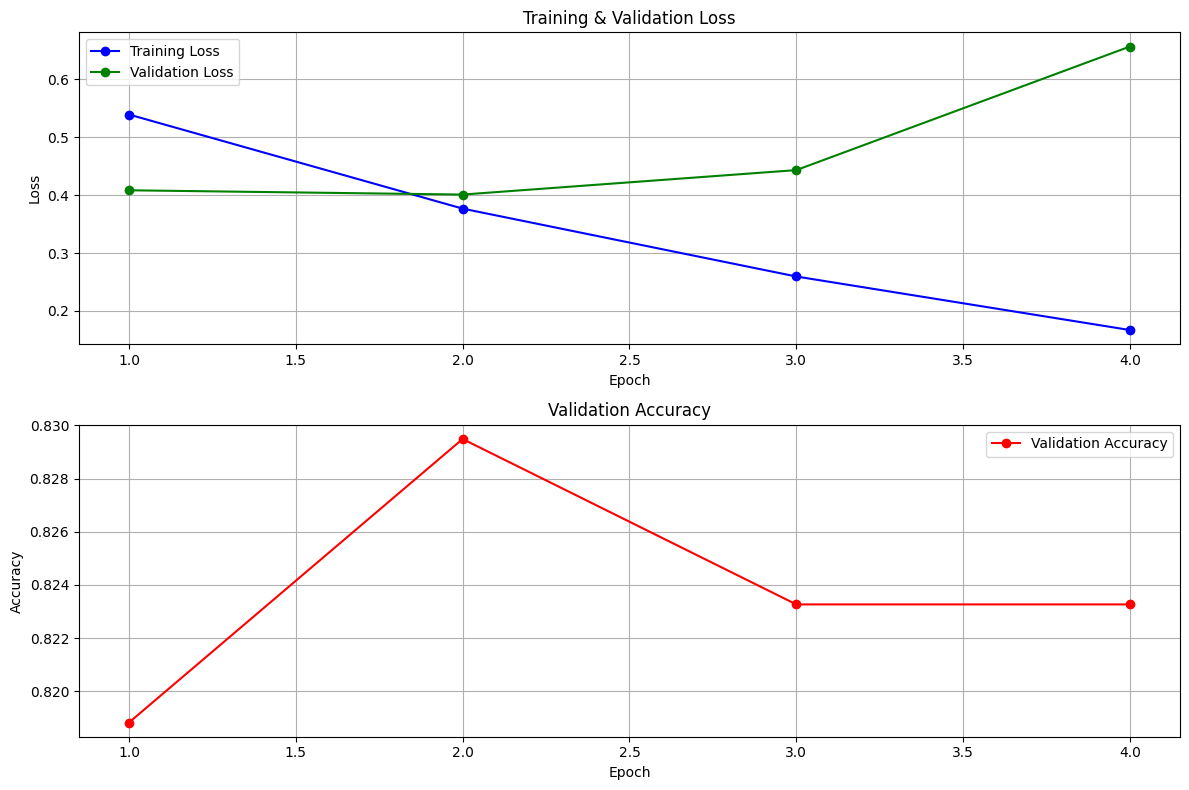

Lưu mô hình vào ./model_save/


AttributeError: 'DistilBertForSentimentAnalysis' object has no attribute 'save_pretrained'

In [ ]:
# Main: Kiểm tra xem đã có các biến cần thiết chưa trước khi huấn luyện
try:
    # Kiểm tra các biến cần thiết
    required_vars = [model, train_dataloader, validation_dataloader, optimizer, scheduler, loss_fn, device]

    # Bắt đầu huấn luyện
    model, training_stats = train_bert_model(
        model=model,
        train_dataloader=train_dataloader,
        validation_dataloader=validation_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn=loss_fn,
        device=device,
        epochs=4
    )

    # Lưu model
    output_dir = './model_save/'
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Lưu mô hình vào {output_dir}")

    # # Lưu model
    torch.save(model.state_dict(), os.path.join(output_dir, 'bert_sentiment_model.pth'))
    # Save model using save_pretrained
    # model.save_pretrained(output_dir)
    print("Đã lưu mô hình bằng save_pretrained")

    # Lưu tokenizer
    try:
        tokenizer.save_pretrained(output_dir)
        print("Đã lưu tokenizer")
    except NameError:
        print("Tokenizer chưa được định nghĩa")

except NameError as e:
    print(f"Lỗi: {e}")
    print("Hãy đảm bảo bạn đã chạy các bước trước (bước 1, 2, 3) để định nghĩa các biến cần thiết")

In [ ]:
def predict_sentiment(comment, model, tokenizer, device, max_length=128):
    model.eval()

    # Tokenize
    inputs = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        return_attention_mask=True
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Tensor logits trực tiếp (không phải tuple)
          # outputs = tensor([[1.2, -0.3], [0.5, 2.1]])  # shape [batch_size, num_classes]
        # Tuple chứa nhiều giá trị (logits ở vị trí đầu tiên)
          # outputs = (tensor([[1.2, -0.3]]), hidden_states, attentions)  # logits là outputs[0]
        logits = outputs[0] if isinstance(outputs, tuple) else outputs
        probs = torch.softmax(logits, dim=1)
        confidence, predicted_label = torch.max(probs, dim=1)

    return [{
        "text": comment,
        "predicted_label": predicted_label.item(),
        "confidence": confidence.item()
    }]


In [ ]:
from google.colab import widgets
import ipywidgets as widgets
from IPython.display import display

# Tạo ô nhập bình luận
input_box = widgets.Text(
    value='',
    placeholder='Nhập bình luận của bạn tại đây...',
    description='Bình luận:',
    layout=widgets.Layout(width='80%')
)

# Nút để chạy dự đoán
button = widgets.Button(description="Dự đoán", button_style='success')

# Hiển thị kết quả dự đoán
output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        text = input_box.value.strip()
        if text:
            result = predict_sentiment(text, model, tokenizer, device)[0]
            print(f"Văn bản: {result['text']}")
            print(f"→ Dự đoán: {'Tích cực' if result['predicted_label'] == 1 else 'Tiêu cực'}")
            print(f"→ Độ tin cậy: {result['confidence']:.4f}")
        else:
            print("Vui lòng nhập bình luận!")

# Gán sự kiện cho nút
button.on_click(on_button_click)

# Hiển thị widget
display(input_box, button, output)
